<a href="https://colab.research.google.com/github/JayThibs/Weak-Supervised-Learning-Case-Study/blob/main/text_classifier/notebooks/05_toxicity_classification_snorkel_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating a Binary Classification Dataset of the Toxicity Dataset with Snorkel

In order to simplify the problem, we are going to turn this multi-label classification problem (does it contain any of these 'bad' labels?) to a binary classification problem (is it a 'bad' comment or not?).

We've already trained a multi-label model for this problem in notebook 01, so why are we doing this? We are doing this for a few reasons:

1. We want to test how well we can create labeling functions with Snorkel to build a dataset without knowing the labels.

2. It takes time to create many labeling functions that create a useful dataset, and it takes longer if it's for a multi-class classification problem, and even longer for multi-label classification. Therefore, in the interest of time, we will make the classification binary.

3. We want to try implementing Active Learning into our prototype and it will be simpler to start with a binary classification model.


Some of the code is borrowed from:

1. https://colab.research.google.com/drive/14Ea4lIzsn5EFvPpYKtWStXEByT9qmbkj?usp=sharing#scrollTo=acF4YRlQL8iz

2. https://www.inovex.de/blog/snorkel-weak-superversion-german-texts/

3. https://trishalaneeraj.github.io/2020-07-26/data-labeling-weak-supervision

In [120]:
!pip install snorkel --quiet
!pip install datasets --quiet
!pip install spacy --quiet
!pip install pip install better-profanity --quiet
!pip install transformers --quiet
# !python -m spacy download en_core_web_md --quiet

     |████████████████████████████████| 96.4MB 1.2MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [126]:
import pandas as pd
from snorkel.labeling import labeling_function
from snorkel.labeling import LabelingFunction
from snorkel.labeling.lf.nlp import nlp_labeling_function
from snorkel.preprocess import preprocessor
from textblob import TextBlob
from better_profanity import profanity
from snorkel.labeling import PandasLFApplier
from sklearn.model_selection import train_test_split
import spacy
from spacy.matcher import Matcher
import numpy as np
nlp = spacy.load("en_core_web_sm")

## Data

Our dataset contains potentially offensive (toxic) comments and comes from the [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge). Let's start by download the data (from Google Drive):

In [3]:
!gdown --id 1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr

Downloading...
From: https://drive.google.com/uc?id=1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr
To: /content/toxic_comments.csv
68.8MB [00:00, 84.2MB/s]


We can take a look at the data:

In [127]:
# we can see 
df = pd.read_csv("toxic_comments.csv")
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the tools well. · talk """,0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0,0,0,0,0,0
8,00037261f536c51d,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contrary to those of DuLithgow,0,0,0,0,0,0


As we can see, we have comments from YouTube videos where most are clean comments, but there are some bad comments that are labeled as either: toxic,	severe_toxic,	obscene,	threat,	insult and/or	identity_hate. We will bunch them all together into the same label we will call 'labels' because Snorkel prefers this.

## Preprocessing

Let's have a look at the dataset before we start creating labeling functions.

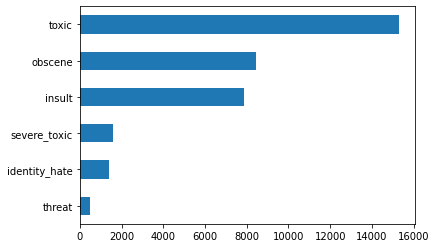

In [128]:
LABEL_COLUMNS = df.columns.tolist()[2:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

Now, let's add them all up together and compare them to the number of clean comments.

In [129]:
train_toxic = train_df[train_df[LABEL_COLUMNS].sum(axis=1) > 0]
train_clean = train_df[train_df[LABEL_COLUMNS].sum(axis=1) == 0]

pd.DataFrame(dict(
  toxic=[len(train_toxic)], 
  clean=[len(train_clean)]
)).plot(kind='barh');

KeyError: ignored

The bad examples are imbalanced, but we will not worry about that. What we will do, however, is to eliminate clean examples from the dataset in order to make it more balanced. We will simply reduce the number of clean comments to a number that is comparable to the toxic comments.

In [130]:
train_df = pd.concat([
  train_toxic,
  train_clean.sample(15_000)
])

print(len(train_df))
train_df.head()

27966


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
148455,4cd75fb3ca00c6bd,"""\n\n """"Taken quite seriously on Wikipedia"""" \n\nYeah, I do realize that. I think being an active contributor to this site makes you a douchebag, which I was kind of hinting at before. I think it's good to """"deter users,"""" or rather stir up the place, because in its proportion to the totality of this shit-project, your little society is shallow and incompetent, proof of the failure of its principles, and on the individual level, that its users are lameasses. I'm having cheap fun, because as far as I know you from interacting with you, you're ridiculously pathetic.""",1,0,0,0,0,0
19001,322c53cebc2b6360,You must be an uglybytch,1,0,1,0,1,0
117811,75508197262bcda9,PAGE GO DIE YOU STUPID ARSEWHOLE AUTOMATED FILTER,1,0,1,0,1,0
32782,574020e0c52f7313,I wanted to let you know that Tymon.r. is a stupid moron.,1,0,1,0,1,0
105519,348b37b92290b83d,I HATE YOU! \n\n I HATE YOU,1,0,0,0,0,0


### Merging All Toxic Comments Together

In [131]:
train_df['label'] = np.where(train_df[LABEL_COLUMNS].sum(axis=1) == 0, 0, 1)
train_df.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label
10501,1bb5ea78222fbdaa,"There is a difference between looking at a stagnated work which is at the base of the experienced authority which is 'helping' while a new user they are swallowing is working? Nobody even asked me if I liked the changes or had planned on something like this. \n\nThere is a difference between articles that are being created by a new author and articles that are left by the people who are dictating style and ranking importance and claiming authority? If you were a skilled yet unranked flautist how would you feel about being swallowed by a group of 5th grade flutophonists? Ranked important by the project and sitting there as evidence of their goals and ability. I gave it the same perusal that I gave other documentation which was presented by people who claimed to know what they were doing in similar venues. If you would like me to look at the document as if it was one of my astronomy students lab assignments, I will do that. The astronomy students never rewrote the lab assignments though and listened politely to my lecture so it would mean a complete change in the relationship for me to conduct this whatever it is as you are suggesting. I never claimed authority over Plant Project it is their claim over my articles. My suggestion is that I was writing a not so bad article while a bunch of 10 year olds were demonstrating how they play kick the can or something like this.\n\nI was one day trying to communicate with a 'pedian who is non-native to English and found it very helpful that the definition that I needed was included in the history of the disambiguation page for the acronym (PITA, in case you care to know this). One of the software strengths of this method of making html is that history stack. Nobody asked me if I agreed to the changes and there is a good chance that I did and had put that into my plans for the whole species that I was working on. We will never know though because a consensus of two determined everything and I considered starting a new user name here called , then wouldn't it?\n\nThere seems to have been some hurt feelings over comparing the attention I got to an amorous dog making use of a human leg I had no idea of such sensitivity among the administration here. carol",0,0,0,0,0,0,0
143810,02fc7e9771c8dadd,"You and your behaviour at the Paris article. It isn't the first time I've seen it but it is the first time I have been the target. You start commenting about the contributor rather than the content then you'll get it back in spades. I'm out of here for a while now due to meds but, believe me, my interest in your antics has suddenly grown immensely. That does not bode well. -",0,0,0,0,0,0,0
135940,d72087606c237d29,"unfortunately it would seem that sql access is disabled for admins atm so a developer would have to do it 05:32, 21 Nov 2004 (UTC)",0,0,0,0,0,0,0
29522,4e4cb3332f16ffe5,It is not a spam website. It is an informative website that helps educate people. You are voilating the rules!! Has anyone complained about the website??,0,0,0,0,0,0,0
58548,9ccb2d853b425514,"""\nOk, thanks. It does seem very anomalous to the """"unknowing eye"""" when the title and the opening part of the lead are formatted differently from one another, yet still emboldened. """,0,0,0,0,0,0,0


In [132]:
train_df = train_df.drop(LABEL_COLUMNS, axis=1)
train_df

,id,comment_text,label
148455,4cd75fb3ca00c6bd,"""\n\n """"Taken quite seriously on Wikipedia"""" \n\nYeah, I do realize that. I think being an active contributor to this site makes you a douchebag, which I was kind of hinting at before. I think it's good to """"deter users,"""" or rather stir up the place, because in its proportion to the totality of this shit-project, your little society is shallow and incompetent, proof of the failure of its principles, and on the individual level, that its users are lameasses. I'm having cheap fun, because as far as I know you from interacting with you, you're ridiculously pathetic.""",1
19001,322c53cebc2b6360,You must be an uglybytch,1
117811,75508197262bcda9,PAGE GO DIE YOU STUPID ARSEWHOLE AUTOMATED FILTER,1
32782,574020e0c52f7313,I wanted to let you know that Tymon.r. is a stupid moron.,1
105519,348b37b92290b83d,I HATE YOU! \n\n I HATE YOU,1
...,...,...,...
10501,1bb5ea78222fbdaa,"There is a difference between looking at a stagnated work which is at the base of the experienced authority which is 'helping' while a new user they are swallowing is working? Nobody even asked me if I liked the changes or had planned on something like this. \n\nThere is a difference between articles that are being created by a new author and articles that are left by the people who are dictating style and ranking importance and claiming authority? If you were a skilled yet unranked flautist how would you feel about being swallowed by a group of 5th grade flutophonists? Ranked important by the project and sitting there as evidence of their goals and ability. I gave it the same perusal that I gave other documentation which was presented by people who claimed to know what they were doing in similar venues. If you would like me to look at the document as if it was one of my astronomy students lab assignments, I will do that. The astronomy students never rewrote the lab assignments though and listened politely to my lecture so it would mean a complete change in the relationship for me to conduct this whatever it is as you are suggesting. I never claimed authority over Plant Project it is their claim over my articles. My suggestion is that I was writing a not so bad article while a bunch of 10 year olds were demonstrating how they play kick the can or something like this.\n\nI was one day trying to communicate with a 'pedian who is non-native to English and found it very helpful that the definition that I needed was included in the history of the disambiguation page for the acronym (PITA, in case you care to know this). One of the software strengths of this method of making html is that history stack. Nobody asked me if I agreed to the changes and there is a good chance that I did and had put that into my plans for the whole species that I was working on. We will never know though because a consensus of two determined everything and I considered starting a new user name here called , then wouldn't it?\n\nThere seems to have been some hurt feelings over comparing the attention I got to an amorous dog making use of a human leg I had no idea of such sensitivity among the administration here. carol",0
143810,02fc7e9771c8dadd,"You and your behaviour at the Paris article. It isn't the first time I've seen it but it is the first time I have been the target. You start commenting about the contributor rather than the content then you'll get it back in spades. I'm out of here for a while now due to meds but, believe me, my interest in your antics has suddenly grown immensely. That does not bode well. -",0
135940,d72087606c237d29,"unfortunately it would seem that sql access is disabled for admins atm so a developer would have to do it 05:32, 21 Nov 2004 (UTC)",0
29522,4e4cb3332f16ffe5,It is not a spam website. It is an informative website that helps educate people. You are voilating the rules!! Has anyone complained about the website??,0


## Preparing the Data for Snorkel

In [133]:
train_df = train_df.rename(columns={"comment_text": "text"})
train_df.head()

,id,text,label
148455,4cd75fb3ca00c6bd,"""\n\n """"Taken quite seriously on Wikipedia"""" \n\nYeah, I do realize that. I think being an active contributor to this site makes you a douchebag, which I was kind of hinting at before. I think it's good to """"deter users,"""" or rather stir up the place, because in its proportion to the totality of this shit-project, your little society is shallow and incompetent, proof of the failure of its principles, and on the individual level, that its users are lameasses. I'm having cheap fun, because as far as I know you from interacting with you, you're ridiculously pathetic.""",1
19001,322c53cebc2b6360,You must be an uglybytch,1
117811,75508197262bcda9,PAGE GO DIE YOU STUPID ARSEWHOLE AUTOMATED FILTER,1
32782,574020e0c52f7313,I wanted to let you know that Tymon.r. is a stupid moron.,1
105519,348b37b92290b83d,I HATE YOU! \n\n I HATE YOU,1


In [134]:
dev_df = train_df.groupby('label').apply(lambda s: s.sample(100, random_state=123)).reset_index(level=0, drop=True)
train_df.drop(dev_df.index, inplace=True)
train_df.drop(['label'], axis=1, inplace=True)

train_df, test_df = train_test_split(train_df, test_size=0.2)
val_df = test_df.sample(frac=0.1)
test_df.drop(val_df.index, inplace=True)

print('Train:', len(train_df), '\t Dev:', len(dev_df), '\t Test:', len(test_df), '\t', 'Valid:', len(val_df))

Train: 22212 	 Dev: 200 	 Test: 4999 	 Valid: 555


## Writing Labeling Functions (LFs)

For clarity, we define constants to represent the class labels for non-toxic, toxic, and abstaining. These will go into our labeling functions so that the constants feed into the labeling process.

In [135]:
ABSTAIN = -1
NONTOXIC = 0
TOXIC = 1

In [136]:
# Useful for looking at the data and creating the labeling functions
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 200)

Let's at a sample of the dataset so that we can come up with labeling functions.

In [138]:
dev_df

,id,text,label
129838,b687038e68c1b229,"Brockville\nI did NOT ADD ANY nonsense to the Brockville page. I just reverted the page back to it's original state because that idiot with ip address 216.106.105.94 changed the whole page. Incase you didn't notice, that same person removed and added bogus information that should not be on the page. NOW what do you think of that??",0
94105,fba98516f8b0715d,The worst to me is that she equates Raneb with Nubnefer like it was obvious and does not mention that this is only an hypothesis.,0
71666,bfe110d196fd576e,"""==Request for Usurpation==\n\nHello, I'm fixed now, I ran a test. A request has been made at Wikipedia:Changing username/Usurpations to usurp, or """"take over"""", your username because you have not used it to edit, and another user would like to use it to edit. Wikipedia:Changing username/Usurpations says that any unused username may be usurped if the user is given seven days notice to object and does not do so. \n\nIf you have an email set in your preferences, you should be getting an email from a bureaucrat or changing username clerk explaining how to consent or object to this process. \n\nIf you do not object to being renamed to a new username in order for another user to utilize the name you currently have, please log in and post a reply here saying so (you may also tell us what username you would like to be renamed to, or we will provide you with a generic one). \n\nIf you do nothing: the request will be filled after seven days, and your account will be moved to a generic username. You may request that it be moved to a new username of your choice at any time.\n\nIf you object to being renamed: please log in and make an edit to this page clearly stating that you object to usurpation. \n\nPlease note that even if your current username is usurped, you can still edit and your data will not be lost; your preferences, watchlist, and other user settings will be transferred to a new username.\n\nThank you for your time. І'm Fixed nоw, I Rаn а Tеst """,0
32961,57b72814f5b6334b,"Way too much speculation here. For the purposes of this article we have to consider Eternals, Deviants and Inhumans to be seperate races, albeit ones that can interbreed with humans. Your suggestion would make the article far too unmanageable.",0
58402,9c56ed52a829fb91,Creation Science \n\nThis article could use some more eyes.,0
135148,d2e95a819ee47a61,"""\n\n Religious views and ministry-Involvement w/ Kenneth Copeland Ministries. \n\nVery good page. Interesting. Mrs Court and her church are partners with Kenneth Copeland Ministries in Fort Worth, Texas. She is featured on page 26 of the Copeland's just issued """"2012 Covenant Partner Report."""" There is a half-page picture of her on that page and a caption of her discussing her use of KCM teaching materials. This is important info for the above-referenced section. """,0
73742,c55565345e94829b,I have begun the process of requesting copyright permission from Ms. Blakely per Wikipedia's instruction.,0
35477,5ec94456c10ea281,"criteria\n(from an AfD): When judging based on a borderline publication record, I look not just at the count of publications and of citations, but the journals in which they were published. Judging by the CV, in this case they are basically very good specialized journals, the leading ones but only in narrow fields. There are known in the most widely read and most rigorously refereed biology or science journals: even one of the papers being in Nature or PNAS would have made this a weak keep. If I had to give evidence for that being a good criterion, I learned this from the provost at Princeton, in a talk explaining the criteria he uses. DGG ( talk )",0
52426,8c43e03af1477041,"""\n\n Battle of Osawatomie \n\nHi-\nI saw your extensive expansion of the this article along with the list of references. Thanks for doing that. Could you add in-line citations for the references where possible. I'll go ahead and add the """"reflist"""" as a Notes 

In [15]:
# Showing the most common words to make the labeling function creation process quicker
# This is where we can come up with a custom keyword list

pd.Series(' '.join(train_df[train_df['label'] == 1].sample(50, random_state=42).text).split()).value_counts()[:50]

the           55
YOU           42
you           36
to            35
a             30
of            30
is            30
I             28
and           25
FUCK          19
THAT          19
SO            19
FOR           17
FACISTS       17
SUPRESSING    17
that          17
on            15
it            13
not           13
your          13
my            11
with          11
in            11
fucking       11
You           10
have          10
are           10
"              9
I'm            9
me             9
at             8
like           8
be             8
for            7
he             7
should         7
this           7
did            7
This           7
there          7
been           6
just           6
u              6
because        6
so             6
by             6
his            6
i              6
get            5
edit           5
dtype: int64

### Labeling Functions

In [16]:
@nlp_labeling_function()
def contains_work_of_art(x):
    """If comment contains titles of books, songs, etc., label non-toxic, else abstain"""
    if any([ent.label_ == "WORK_OF_ART" for ent in x.doc.ents]):
        return NONTOXIC
    else:
        return ABSTAIN
    
@nlp_labeling_function()
def contains_entity(x):
    """If comment contains least 3 mentions of an entity, label non-toxic, else abstain"""
    if len([ent.label_ in ["PERSON", "GPE", "LOC", "ORG", "LAW", "LANGUAGE"] for ent in x.doc.ents])>2:
        return NONTOXIC
    else:
        return ABSTAIN

In [17]:
@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(x.text)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

@labeling_function(pre=[textblob_sentiment])
def textblob_polarity(x):
    """If comment has a polarity score between +0.9 and +1, label non-toxic, else abstain"""
    return NONTOXIC if x.polarity > 0.9 else ABSTAIN

@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    """If comment has a subjectivity score between +0.7 and +1, label non-toxic, else abstain"""
    return NONTOXIC if x.subjectivity >= 0.7 else ABSTAIN

In [18]:
# @labeling_function()
# def contains_profanity(x):
#     """
#     If comment contains profanity label toxic, else abstain. 
#     Profanity determined using this library - https://github.com/snguyenthanh/better_profanity
#     """
#     return TOXIC if profanity.contains_profanity(x.text) else ABSTAIN

In [19]:
nlp = spacy.load("en_core_web_sm")

# @nlp_labeling_function()
# def contains_pleaseread(x):
#     """
#     Will match commonly occuring phrases like - 
#     Please read this
#     Please read the
#     Please read
#     """
#     matcher = PhraseMatcher(nlp.vocab)
#     pattern = [{"LEMMA": "please"},
#                {"LEMMA": "read"},
#                {"LEMMA": "the", "OP": "?"},
#                {"LEMMA": "this", "OP": "?"}]
#     matcher.add("p1", None, pattern)
#     matches = matcher(x.doc)
#     return NONTOXIC if len(matches)>0 else ABSTAIN

@nlp_labeling_function()
def contains_stopvandalizing(x):
    """
    Will match commonly occuring phrases like - 
    stop vandalizing
    do not vandalize
    don't vandalize
    """
    matcher = PhraseMatcher(nlp.vocab)
    pattern1 = ["do not vandalize", 'vandalize']
    pattern2 = [{"LEMMA": "stop"}, 
                {"LEMMA": "vandalize"}]
    matcher.add("p1", None, pattern1)
    matcher.add("p2", None, pattern2)
    matches = matcher(x.doc)
    return NONTOXIC if len(matches)>0 else ABSTAIN
    
# @nlp_labeling_function()
# def contains_harassme(x):
#     """
#     Will match commonly occuring phrases like - 
#     harass me
#     harassed me
#     harassing me
#     """
#     matcher = Matcher(nlp.vocab)
#     pattern = [{"LOWER": "harass"}, 
#                {"LOWER": "me"}]
#     matcher.add("p1", None, pattern)
#     matches = matcher(x.doc)
#     return NONTOXIC if len(matches)>0 else ABSTAIN

# @nlp_labeling_function()
# def contains_willreport(x):
#     """Will match commonly observed phrases like - 
#     report you
#     reported you
#     reporting you
#     reported your
#     """
#     matcher = Matcher(nlp.vocab)
#     pattern = [{"LEMMA": "report"}, 
#                {"LEMMA": "you"}]
#     matcher.add("p1", None, pattern)
#     matches = matcher(x.doc)
#     return NONTOXIC if len(matches)>0 else ABSTAIN

In [20]:
@nlp_labeling_function()
def contains_email(x):
    """If comment contains email address, label non-toxic, else abstain"""
    matcher = Matcher(nlp.vocab)
    pattern = [{"LIKE_EMAIL": True}]
    matcher.add("p1", None, pattern)
    matches = matcher(x.doc)
    return NONTOXIC if len(matches)>0 else ABSTAIN
    
@nlp_labeling_function()
def contains_url(x):
    """If comment contains url, label non-toxic, else abstain"""
    matcher = Matcher(nlp.vocab)
    pattern = [{"LIKE_URL": True}]
    matcher.add("p1", None, pattern)
    matches = matcher(x.doc)
    return NONTOXIC if len(matches)>0 else ABSTAIN

In [23]:
def keyword_lookup(x, keywords, label):
    if any(word in x.text.lower() for word in keywords):
        return label
    return ABSTAIN

def make_keyword_lf(keywords, label=TOXIC):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )

# with open('badwords.txt') as f:
#     toxic_stopwords = f.readlines()

# toxic_stopwords = [x.strip() for x in toxic_stopwords] # len = 458
# """Comments mentioning at least one of Google's Toxic Stopwords 
# https://code.google.com/archive/p/badwordslist/downloads are likely toxic"""
# keyword_toxic_stopwords = make_keyword_lf(keywords=toxic_stopwords)

keyword_please = make_keyword_lf(keywords=["please", "plz", "pls", "pl", "Please read this", "Please read the", "Please read"], label=NONTOXIC)

keyword_thanks = make_keyword_lf(keywords=["thanks", "thank you", "thx", "tx"], label=NONTOXIC)

In [24]:
@labeling_function()
def capslock(x):
    """If comment is written in all caps, label toxic, else abstain"""
    return TOXIC if x.text == x.text.upper() else ABSTAIN

In [78]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

In [79]:
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
sentiment_pipeline('and I am a homosexual. I think I am better Wikipedia user than you. Please refrain from making edits to the site. Thank you. That is all, asswhipe.')[0]

{'label': '1 star', 'score': 0.6375729441642761}

In [86]:
sentiment_pipeline('this video was fucking awesome')[0].values()

dict_values(['5 stars', 0.7866018414497375])

In [ ]:
@labeling_function()
def lf_bert_sentiment(x):
    """ Hatespeech may have a negative sentiment.
        
    Ranks the text given a sentiment from a pretrained bert transformer for movie reviews sentiment analysis.
    Note: For larger datasets, we should compute this in batches and ahead-of-time.
    """

    label, proba = sentiment_pipeline(x.text)[0].values()
    if label == '1 star' and proba >= 0.5:
        return TOXIC
    if label == '3 star' and proba >= 0.5:
        return NONTOXIC
    if label == '4 star' and proba >= 0.5:
        return NONTOXIC
    if label == '5 star' and proba >= 0.5:
        return NONTOXIC
    return ABSTAIN

In [25]:
lfs = [
      contains_work_of_art,
      contains_entity,
      textblob_polarity,
      textblob_subjectivity,
      # contains_profanity,       # Removed: 62% accuracy, removed to make labeling faster
      # contains_pleaseread,
      contains_stopvandalizing,
      # contains_harassme,        # Removed: 50% on 4 examples
      # contains_willreport,      # Removed: labels 1 example and gets it wrong
      contains_email,
      contains_url,
      # keyword_toxic_stopwords,  # Removed: 22% accuracy
      keyword_please,
      keyword_thanks,
      # capslock                  # Removed: 55% accuracy, doesn't label many examples
      lf_bert_sentiment
]

## Applying the Labeling Functions

In [26]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=train_df)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 30463/30463 [26:58<00:00, 18.82it/s]


In [38]:
L_val = applier.apply(df=val_df)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 7979/7979 [07:14<00:00, 18.38it/s]


In [27]:
import pickle

with open('L_train_toxic_1.pkl','wb') as f:
  pickle.dump(L_train, f)
with open('L_train_toxic_1.pkl','rb') as f:
  L_train = pickle.load(f)
  print(L_train.shape)

(30463, 10)


In [28]:
L_train

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1,  0, -1, ..., -1,  0, -1],
       [-1, -1, -1, ..., -1,  0, -1],
       ...,
       [-1,  0, -1, ..., -1,  0, -1],
       [-1,  0, -1, ..., -1,  0,  0],
       [-1, -1, -1, ..., -1,  0, -1]])

In [29]:
from snorkel.labeling import LFAnalysis
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
contains_work_of_art,0,[0],0.059843,0.053409,0.0
contains_entity,1,[0],0.298001,0.205922,0.0
textblob_polarity,2,[0],0.003709,0.002725,0.0
textblob_subjectivity,3,[0],0.171224,0.058563,0.0
contains_pleaseread,4,[0],0.002692,0.002692,0.0
contains_stopvandalizing,5,[0],0.004432,0.004038,0.0
contains_email,6,[0],0.001805,0.001444,0.0
contains_url,7,[0],0.030956,0.024719,0.0
keyword_please,8,[0],0.322588,0.214391,0.0
keyword_thanks,9,[0],0.080097,0.057053,0.0


In [30]:
from snorkel.labeling.model import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

In [72]:
val_df

,id,text,labels
155376,bcd794ddc143f4a1,"(UTC)\n\nI wholeheartedly disagree. If you choose to annotate things using the Christian calendar, then AD should be the default. CE and BCE are and affront to the people whose calendar you're using. Use another calendar if you don't want to use the proper notation. 21:03, 11 March 2014",0
72551,c2252b14e80ca744,"Hello, please refrain from pushing your views on Wikipedia. I understand that you identify strongly with and support the values of the former illegal state: The Confederate States of America which was founded on the principals of racism and slavery. Since these are extremist and reactionary positions in our modern society, I recommend you think carefully about whether your contributions truly advance the goals of Wikipedia. Thank you.\n\nBest,\n\nAnonWikiCitizen",0
112660,5ab4d9dd112bcf08,"This is not an article about scholarship on the Cold War, but an article about the Cold War itself; scholarship of all sorts, traditional or not, should be allowed if reliable and germain.",0
115119,6786b6599e32031f,"""The problem with saying that Warren G. Harding was the first African-American President is that it is a theory that is unproven by fact. While many people believe this concept - some even go to great lengths to self publish books on the topics, there is no way to scientifically prove the concept, nor is there any way to verify generally accepted documents that could show this is even a possibility. The rumor that Harding was black rages about based on two quotes, one by Harding himself (where he says he doesn't know if it could be true, the other a rumor started by his future father-in-law meant to destroy Harding's business and reputation.) Consider verifiable these FACTS on the matter:\n1) Harding's alleged """"black"""" lineage can not be proven through United States Census forms, death certificate, or any other PRIMARY SOURCE document. As far back as the 1850 census (the first to name all people enumerated, and designate their race) Harding's father and mother are enumerated as white. This is most frequently dismissed by Harding Conspiracy followers who claim the census forms were doctored after the fact as part of a Federal Government cover-up.\n\n2) There is no DNA proof of Harding's alleged """"black blood"""", (nor is there proof that Harding fathered Elizabeth Ann Christian).\n\n3) Harding was not raised as a cultural """"black"""" that is to say that he was not raised within the black community, and therefore would have not had the same cultural experiences that other blacks in the era would have had.\n\n4) """"Black Harding"""" promoters will point to William Estabrook Chancellor's book on Harding as proof of government conspiracy. And it is interesting how swifty the government worked to squash the book and get its copies. But if one looks at Chancellor's research methodology (and we step away from those who claim that the book was supressed) - all of it based on hearsay - any student in college today who would present this type of research in the form of a paper, masters thesis or dissertation would have been thrown out of college for faulty research! \n\n5) Some of the promoters of this theory of Harding's """"blackness"""" on """"family stories"""". While folklore is not always untrue, folklore can be embellished from storyteller to storyteller. Ask anyone who studies it, folklore is at the mercy of the one who passes it on.\n\n6) The promoters of these theories go to great lengths to attack the people who poke logical holes in their wishful arguments. They can not refute the facts, so they attack the people who question their beliefs. Take a look at the """"reviews"""" of Harding books published in the past ten years in places like Amazon and B&N; online and you'll get an idea how some people will attack those who do not buy into the black """"Black Harding"""" myth.\n\nIf Wikipedia were to add information that Harding was the first black President, without irrf

In [45]:
Y_val = val_df.labels.values
LFAnalysis(L_val, lfs).lf_summary(Y_val)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
contains_work_of_art,0,[0],0.079208,0.070811,0.0,605,27,0.957278
contains_entity,1,[0],0.361073,0.255420,0.0,2719,162,0.943770
textblob_polarity,2,[0],0.005640,0.003760,0.0,43,2,0.955556
textblob_subjectivity,3,[0],0.112044,0.052262,0.0,706,188,0.789709
contains_pleaseread,4,[0],0.003509,0.003509,0.0,28,0,1.000000
contains_stopvandalizing,5,[0],0.004888,0.004387,0.0,38,1,0.974359
contains_email,6,[0],0.001880,0.001504,0.0,15,0,1.000000
contains_url,7,[0],0.039855,0.031959,0.0,309,9,0.971698
keyword_please,8,[0],0.391277,0.270836,0.0,2940,182,0.941704
keyword_thanks,9,[0],0.120566,0.084346,0.0,940,22,0.977131


In [50]:
correct_examples = LFAnalysis(L_val, lfs).lf_summary(Y_val)['Correct'].sum()
incorrect_examples = LFAnalysis(L_val, lfs).lf_summary(Y_val)['Incorrect'].sum()
total_examples = correct_examples + incorrect_examples

print('Number of Correct Examples: ' + str(correct_examples))
print('Number of Correct Examples: ' + str(incorrect_examples))
print('Percentage of Correct Examples: ' + str(100 * correct_examples / total_examples) + '%')

Number of Correct Examples: 8343
Number of Correct Examples: 593
Percentage of Correct Examples: 93.363921217547%


In [51]:
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True)
vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize, ngram_range=(1, 3))

In [53]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state=42)

In [58]:
from snorkel.labeling import filter_unlabeled_dataframe
from snorkel.utils import probs_to_preds
snorkel_label_probs = label_model.predict_proba(L=L_train)
X, y = filter_unlabeled_dataframe(X=train_df.text, y=snorkel_label_probs, L=L_train)
X = vectorizer.fit_transform(X)
classifier.fit(X, probs_to_preds(probs=y))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [61]:
X = vectorizer.transform(val_df.text.tolist())
y_true = val_df.labels.values    
y_pred = classifier.predict(X)

'              precision    recall  f1-score   support\n\n           0       0.92      1.00      0.96      7217\n           1       0.91      0.19      0.31       762\n\n    accuracy                           0.92      7979\n   macro avg       0.92      0.59      0.63      7979\nweighted avg       0.92      0.92      0.90      7979\n'

In [77]:
pd.DataFrame(y_pred).sum()

0    155
dtype: int64

In [63]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      7217
           1       0.91      0.19      0.31       762

    accuracy                           0.92      7979
   macro avg       0.92      0.59      0.63      7979
weighted avg       0.92      0.92      0.90      7979



In [65]:
train_df

,id,text,labels
134827,d11ceb3723d263bc,Blah Blah Blah. Cry me a river. Go suck a prick.,1
123055,9240c1fb4e5caf01,"""::So Hersford gets away with this? Because I stand up to this moral choice, I get fucked over with two or three warnings on my page? Instead someone doesn't warn Hersford for his bad choice? Please note his long excuse filled statement on his page. Does that not read like an attack on me? I don't like to be attacked, and he was caught for a big mistake, so instead of immediately reconsidering his mistake, he went on the attack. An age-old public relations ploy, which I don't buy. Hersford may or may not be a racist, but he certainly let an avowed racist get away with something. Sad. Talk• Contributions \n""",1
37107,630c54de93671c68,"""\n\nI JUST GAVE PROOF THEY ARE OK AND YOU BLEW ME THE HELL OFF. You are annoying me. I gave plenty of proof and you reply with an """"they are fan sites. fan sites are bad"""" answer. It is oh. so. amazing how ignored me completely. JUSTICE IS SERVED! """,1
12861,2215d63992760558,"NOT REALLY, GO AHEAD AND FUCK OFF BITCH!!!",1
64710,ad2e69231dd81818,who are you \n\nfuck?? 182.16.240.42,1
...,...,...,...
27174,47e41c90d46dda5d,"""\n\nProposed move to Social Darwinism\nHaving discussed the point here, there seems to be no reason not to move the page back to Social Darwinism to comply with the Wikipedia:Manual of Style (capital letters)#Religions, deities, philosophies, doctrines and their adherents section which concludes that """"Philosophies, theories, doctrines, and systems of thought do not begin with a capital letter, unless the name derives from a proper noun:"""". As Darwinism derives from the proper noun """"Darwin"""" it should always begin with a capital letter, thus Social Darwinism is correct. Anyone differ from this assessment? .. , talk """,0
93187,f92ad99ccff7ce2d,"In 1952 Ragual Samuel Rahator published Christology and Krishnology, a Critical Study, through Northwestern University.Christology and Krishnology, a Critical Study Northwestern University",0
131918,c1e606856701121a,"The comment about the horns was just a joke. I was just emphasizing how this article has a lot of weasel words in it that are more opinion than fact.\n\nRamdrake is shooting down everything I argue about. I'm obviously not the only person who has issues with this article. I don't see why we can't make it longer and include all of rushton's theories while also leaving plenty of room for critics. \n\nI think we should open this article up. I mean it's better if the article is twice as long and has his theories, critiques, and everything. Then everyone will be happy, but as the article stands it is just not very good. Ramdrake seems to want to have an article only on criticism, but there are many other people who would contribute more. Let's allow them to do it. I mean the article is fairly short as it is.",0
147913,43a691685854396c,You are no fun. I give up. But the edits will still remain there as my proof that I have won the war of truths against Wikipedia. 218.186.13.2,0


In [68]:
len(val_df[val_df['labels'] == 1]), len(val_df[val_df['labels'] == 0])

(762, 7217)